# Importing libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import cv2 
from PIL import Image
from tqdm.auto import tqdm 
import glob as gb 


import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.optim import Adam , lr_scheduler 
import torchvision 
from torchvision import datasets 
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader , Dataset
from torchsummary import summary
from torchmetrics import ConfusionMatrix 
from mlxtend.plotting import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score 

# Loading the dataset

In [2]:
def walk_through_data(dir_path) : 
    for dirpath , dirnames , filenames in tqdm(os.walk(dir_path)) : 
        print(f"There are {len(dirnames)} directions and {len(filenames)} images in {dirpath}")

In [3]:
dataset_path = 'train_test_dev' 
pred_path = 'pred_dev'

In [4]:
walk_through_data(dataset_path)

0it [00:00, ?it/s]

There are 4 directions and 0 images in train_test_dev
There are 0 directions and 8950 images in train_test_dev\MildDemented
There are 0 directions and 6454 images in train_test_dev\ModerateDemented
There are 0 directions and 9590 images in train_test_dev\NonDemented
There are 0 directions and 8950 images in train_test_dev\VeryMildDemented


In [5]:
walk_through_data(pred_path)

0it [00:00, ?it/s]

There are 1 directions and 0 images in pred_dev
There are 0 directions and 40 images in pred_dev\pred


In [6]:
extension = [] 
classes = [] 

for folder in tqdm(os.listdir(dataset_path)) : 
    
    if folder not in classes : 
        classes.append(folder)
        
    for file in os.listdir(dataset_path + "/" + folder + "/") : 
        if os.path.isfile(dataset_path + "/" + folder + "/" + file) : 
            extension.append(os.path.splitext(file)[1])

  0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
print(len(extension) , np.unique(extension))

33944 ['.jpg']


In [8]:
classes

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [9]:
class_labels = {key : value for value , key in enumerate(classes)}
class_labels

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [10]:
def getlabel(n) : 
    for x , y in class_labels.items() : 
        if y==n : 
            return x

In [11]:
num_of_disease = {} 

for disease in tqdm(classes) : 
    num_of_disease[disease] = len(os.listdir(dataset_path + "/" + disease))

  0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
img_per_class = pd.DataFrame(num_of_disease.values() 
                             , index = num_of_disease.keys() , 
                             columns = ["# of images"]
                            )

img_per_class

,# of images
MildDemented,8950
ModerateDemented,6454
NonDemented,9590
VeryMildDemented,8950


Text(0.5, 1.0, 'Images per each class of plant disease')

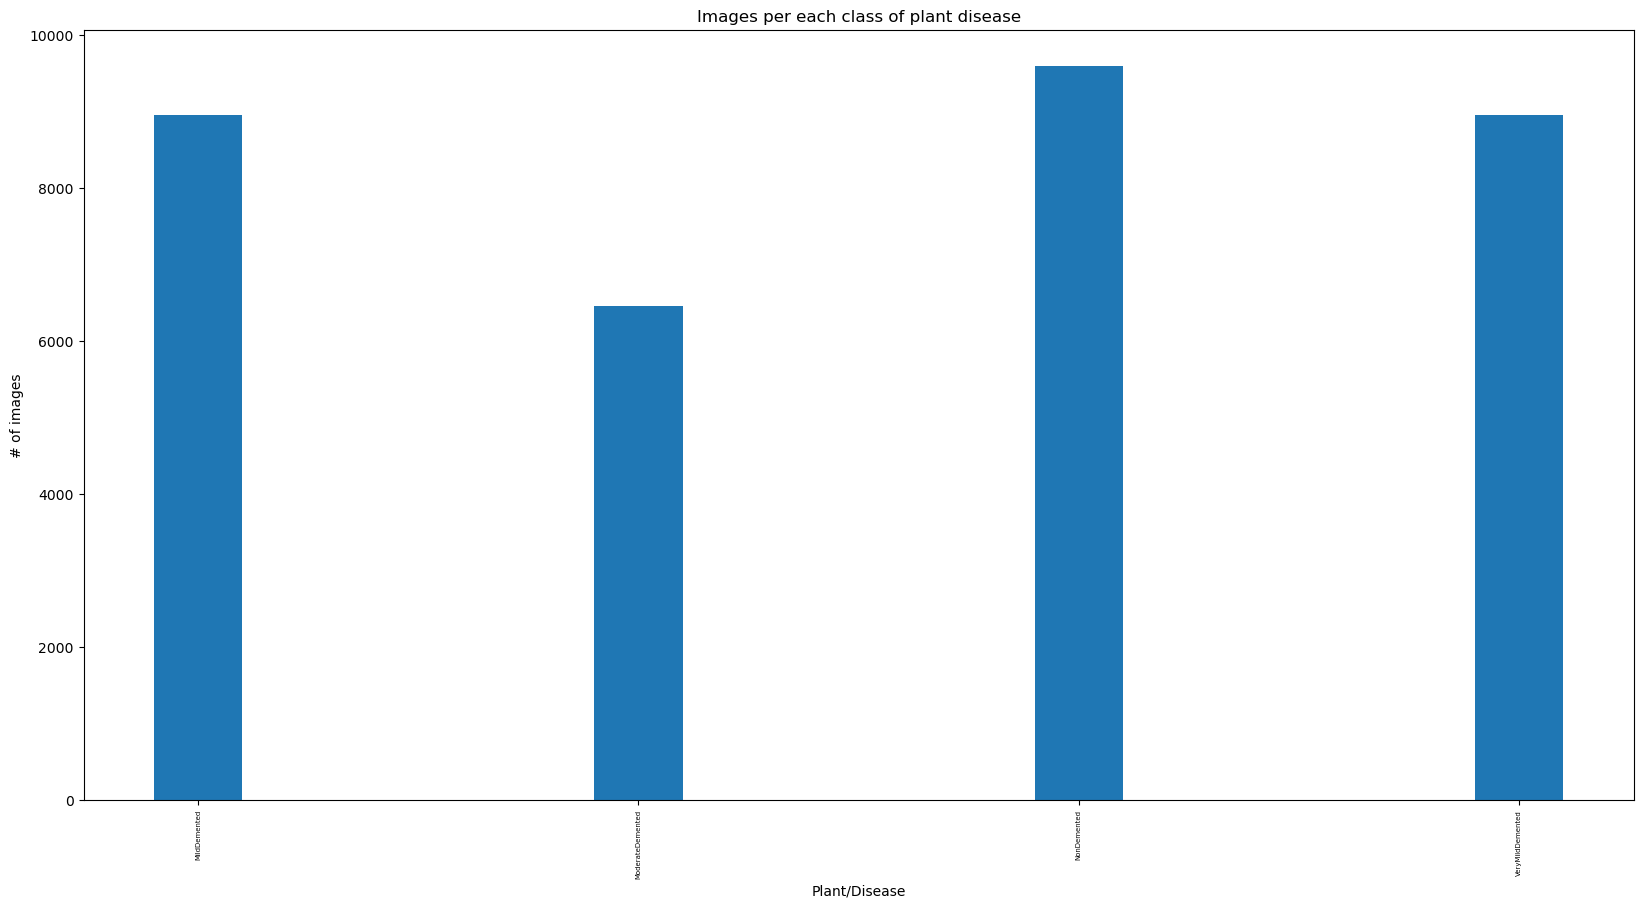

In [13]:
idx = [i for i in range(len(classes))]
plt.figure(figsize = (20,10))
plt.bar(idx , [n for n in num_of_disease.values()] , width = 0.2)
plt.xlabel('Plant/Disease' , fontsize = 10) 
plt.ylabel('# of images')
plt.xticks(idx , classes , fontsize = 5 , rotation = 90)
plt.title('Images per each class of plant disease')

In [14]:
dataset_path_list = [] 
dataset_labels = [] 

for folder in tqdm(os.listdir(dataset_path)) : 
    files = gb.glob(pathname = str(dataset_path + "/" + folder + "/*.jpg"))
    for file in files : 
        dataset_path_list.append(file)
        dataset_labels.append(class_labels[folder])

  0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
len(dataset_path_list) , len(dataset_labels)

(33944, 33944)

In [16]:
np.unique(dataset_labels)

array([0, 1, 2, 3])

In [17]:
pred_path_list = [] 

for folder in tqdm(os.listdir(pred_path)) : 
    files = gb.glob(pathname = str(pred_path + "/" + folder + "/*.jpg"))
    for file in files : 
        pred_path_list.append(file)

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
pred_labels = []
for folder in tqdm(os.listdir(pred_path)) :     
    for file in os.listdir(pred_path + "/" + folder + "/") : 
        if os.path.isfile(pred_path + "/" + folder + "/" + file) : 
            pred_labels.append(os.path.splitext(file)[0])

  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
len(pred_path_list) , len(pred_labels)

(40, 40)

In [20]:
np.unique(pred_labels)

array(['MildDem1', 'MildDem10', 'MildDem2', 'MildDem3', 'MildDem4',
       'MildDem5', 'MildDem6', 'MildDem7', 'MildDem8', 'MildDem9',
       'ModerateDem1', 'ModerateDem10', 'ModerateDem2', 'ModerateDem3',
       'ModerateDem4', 'ModerateDem5', 'ModerateDem6', 'ModerateDem7',
       'ModerateDem8', 'ModerateDem9', 'NonDem1', 'NonDem10', 'NonDem2',
       'NonDem3', 'NonDem4', 'NonDem5', 'NonDem6', 'NonDem7', 'NonDem8',
       'NonDem9', 'VeryMildDem1', 'VeryMildDem10', 'VeryMildDem2',
       'VeryMildDem3', 'VeryMildDem4', 'VeryMildDem5', 'VeryMildDem6',
       'VeryMildDem7', 'VeryMildDem8', 'VeryMildDem9'], dtype='<U13')

# Split the dataset

In [21]:
train_path_list , test_path_list , train_labels , test_labels = train_test_split(dataset_path_list , dataset_labels , train_size = 0.80 , random_state = 0)

In [22]:
len(train_path_list) , len(train_labels) , len(test_path_list) , len(test_labels)

(27155, 27155, 6789, 6789)

# Turning our data into tensors

In [23]:
img_size = 224 

In [24]:
basic_transform = transforms.Compose([
    transforms.Resize(size = (img_size , img_size)) , 
    transforms.ToTensor()
])

In [25]:
class InvalidDatasetException(Exception):
    
    def __init__(self,len_of_paths,len_of_labels):
        super().__init__(
            f"Number of paths ({len_of_paths}) is not compatible with number of labels ({len_of_labels})"
        )

In [26]:
class train_data(Dataset) : 
    def __init__(self , train_path , train_label , transform_method) : 
        self.train_path = train_path 
        self.train_label = train_label 
        self.transform = transform_method 
        if len(self.train_path) != len(self.train_label) : 
            raise InvalidDatasetException(self.train_path , self.train_label)
            
            
    def __len__(self) : 
        return len(self.train_path)
    
    
    def __getitem__(self , index) : 
        image = Image.open(self.train_path[index])
        tensor_image = self.transform(image)
        label = self.train_label[index]
        
        return tensor_image , label

In [27]:
train_set = train_data(train_path_list , train_labels , basic_transform)

In [28]:
np.unique(train_set.train_label)

array([0, 1, 2, 3])

In [29]:
print(f"The number of images in the train set is : {train_set.__len__()}")

The number of images in the train set is : 27155


In [30]:
filer_train_image=train_set.__getitem__(1000)

In [31]:
filer_train_image[0].shape

torch.Size([3, 224, 224])

In [32]:
getlabel(filer_train_image[1])

'ModerateDemented'

In [33]:
class test_data(Dataset) : 
    def __init__(self, test_path ,test_label , transform_method) : 
        self.test_path = test_path 
        self.test_label = test_label 
        self.transform = transform_method 
        if len(self.test_path) != len(self.test_label):
            raise InvalidDatasetException(self.test_path,self.test_label)
            
    def __len__(self) : 
        return len(self.test_path)
    
    
    def __getitem__(self , index) : 
        image = Image.open(self.test_path[index])
        tensor_image = self.transform(image)
        label = self.test_label[index]
        
        return tensor_image , label 
            

In [34]:
test_set = test_data(test_path_list , test_labels , basic_transform)

In [35]:
np.unique(test_set.test_label)

array([0, 1, 2, 3])

In [36]:
print(f"The number of images in the test set is : {test_set.__len__()}")

The number of images in the test set is : 6789


In [37]:
filer_test_image = test_set.__getitem__(200)

In [38]:
filer_test_image[0].shape

torch.Size([3, 224, 224])

In [39]:
getlabel(filer_test_image[1])

'NonDemented'

In [40]:
class pred_data(Dataset) : 
    def __init__(self , pred_path , transform_method) : 
        self.pred_path = pred_path 
        self.transform = transform_method 
        
        
    def __len__(self) :
        return len(self.pred_path)
    
    
    def __getitem__(self , index) : 
        image = Image.open(self.pred_path[index])
        tensor_image = self.transform(image)
        
        return tensor_image 

In [41]:
pred_set = pred_data(pred_path_list , basic_transform)

In [42]:
print(f"The number of images in the pred set is : {pred_set.__len__()}")

The number of images in the pred set is : 40


In [43]:
filer_pred_image = pred_set.__getitem__(10)

In [44]:
filer_pred_image.shape

torch.Size([3, 224, 224])

# Create dataloaders for our train , test and pred data

In [45]:
BATCH_SIZE = 128 

In [46]:
train_dataloader = DataLoader(
    dataset = train_set , 
    batch_size = BATCH_SIZE , 
    shuffle = True
)

In [47]:
test_dataloader = DataLoader(
    dataset = test_set , 
    batch_size = BATCH_SIZE , 
    shuffle = False 
)

In [48]:
pred_dataloader = DataLoader(
    dataset = pred_set , 
    batch_size = pred_set.__len__() , 
    shuffle = False
)

In [49]:
print(f"the size of the train dataloader {len(train_dataloader)} batches of {BATCH_SIZE}")

the size of the train dataloader 213 batches of 128


In [50]:
trainimage_sample , trainlabel_sample = next(iter(train_dataloader))
trainimage_sample.shape , trainlabel_sample.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

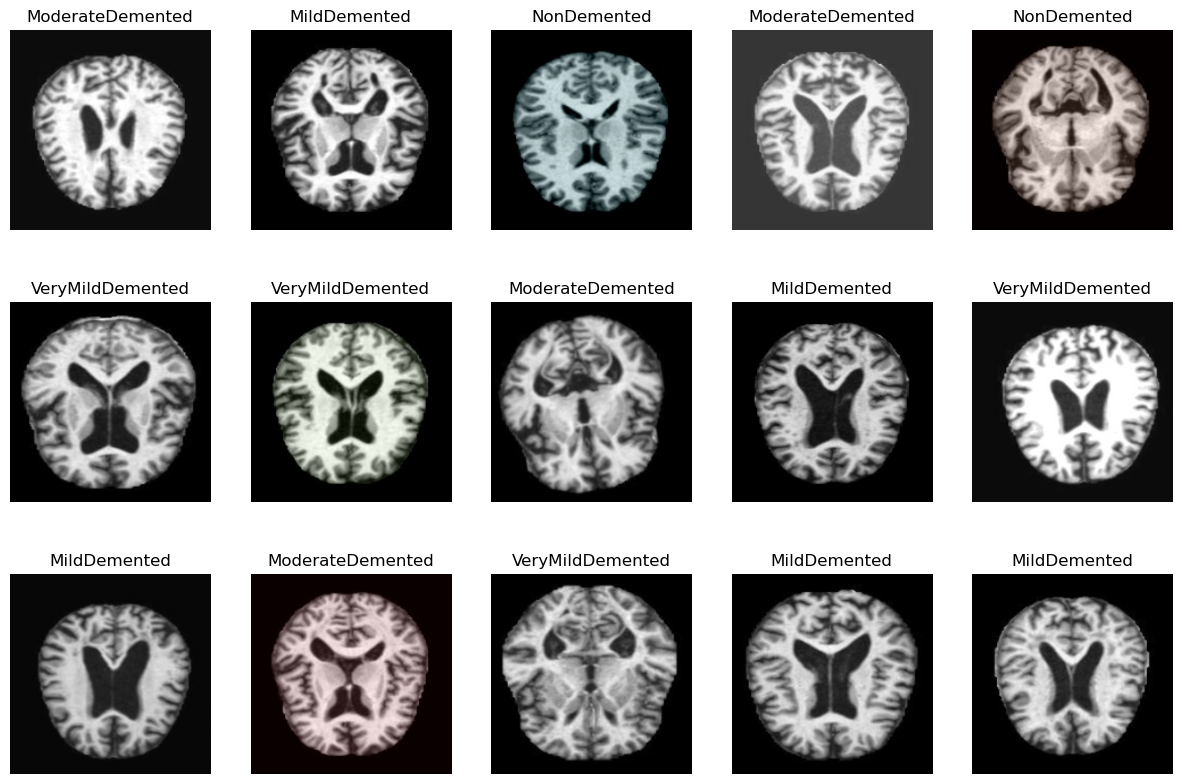

In [51]:
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        img = trainimage_sample[i].numpy()
        img = np.transpose(img, (1, 2, 0))
        ax.imshow(img)
        ax.set(title = f"{getlabel(trainlabel_sample[i])}")
        ax.axis('off')

In [52]:
print(f"the size of the test dataloader {len(test_dataloader)} batches of {BATCH_SIZE}")

the size of the test dataloader 54 batches of 128


In [53]:
testimage_sample , testlabel_sample = next(iter(test_dataloader))
testimage_sample.shape , testlabel_sample.shape 

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

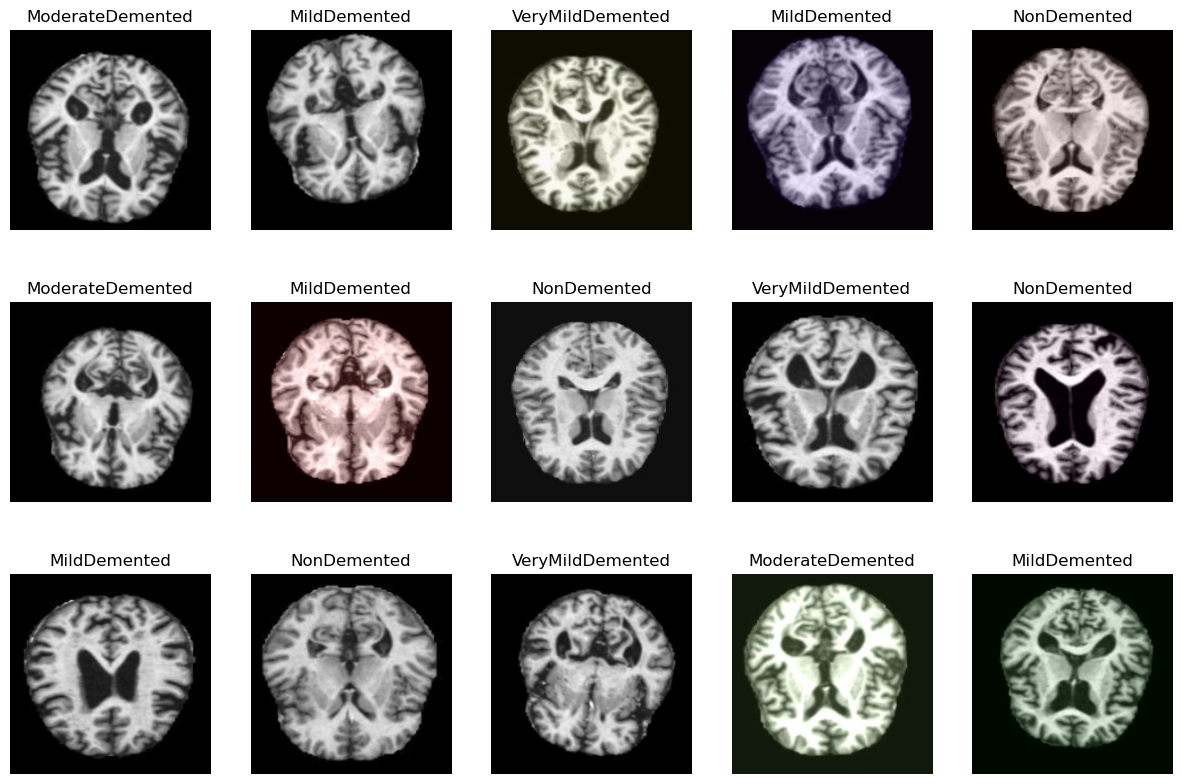

In [54]:
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        img = testimage_sample[i].numpy()
        img = np.transpose(img, (1, 2, 0))
        ax.imshow(img)
        ax.set(title = f"{getlabel(testlabel_sample[i])}")
        ax.axis('off')

In [55]:
print(f"the size of the pred dataloader {len(pred_dataloader)}")

the size of the pred dataloader 1


In [56]:
predimage_sample = next(iter(pred_dataloader))
predimage_sample.shape

torch.Size([40, 3, 224, 224])

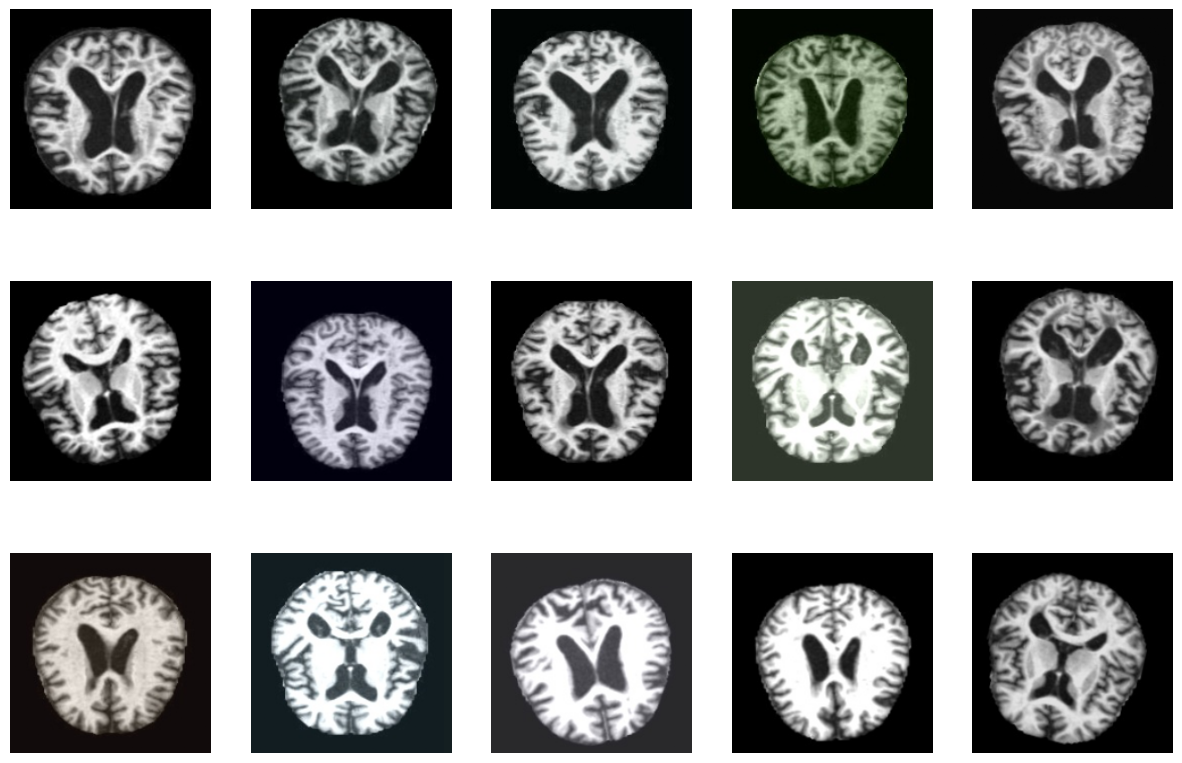

In [57]:
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        img = predimage_sample[i].numpy()
        img = np.transpose(img, (1, 2, 0))
        ax.imshow(img)
        ax.axis('off')

# Build the model

In [58]:
def param_count(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print('Total number of parameters : ', sum(params))

In [59]:
def convblock(in_channels , out_channels , pool = False ) : 
    layers = [
        nn.Conv2d(
            in_channels = in_channels  , 
            out_channels = out_channels , 
            kernel_size = 3 , 
            padding = 1
        ) , 
        
        nn.BatchNorm2d(out_channels) , 
        
        nn.ReLU(inplace = True)
    ]
    
    if pool : 
        layers.append(nn.MaxPool2d(kernel_size = 4))
        
    return nn.Sequential(*layers)

In [82]:
class CNN(nn.Module) : 
    def __init__(self,input_shape , output) : 
        super().__init__()
        
        self.conv1 = convblock(input_shape , 32) 
        
        self.conv2 = convblock(32 , 64 , pool = True)

        self.res1 = convblock(64,64)
        
        self.conv3 = convblock(64 , 128 , pool = True) 
        
        self.conv4 = convblock(128 , 256 , pool = True) 

        self.res2 = convblock(256 , 256)
        
        self.fc = nn.Sequential( 
            nn.Flatten() ,
            nn.Linear(256*3*3 , output)
        )
        
        
    def forward(self,x) : 
        out = self.conv1(x)

        out = self.conv2(out) 

        out = self.res1(out) + out 
        
        out = self.conv3(out)

        out = self.conv4(out) 

        out = self.res2(out) + out 
         
        out = self.fc(out)
        
        
        return out

In [83]:
torch.manual_seed(42)
model=CNN(
    input_shape = 3 , 
    output=len(classes)
)

In [84]:
model.parameters

<bound method Module.parameters of CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    

In [85]:
param_count(model)

Total number of parameters :  1026244


In [86]:
in_shape = (3, 224, 224)
print(summary(model, (in_shape)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          18,496
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]          73,856
      BatchNorm2d-12          [-1, 128, 56, 56]             256
             ReLU-13          [-1, 128, 56, 56]               0
        MaxPool2d-14          [-1, 128,

In [87]:
criterion=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=0.01)

# Training the model

In [88]:
epochs = 10 
training_acc = [] 
training_loss = [] 

for i in tqdm(range(epochs)) : 
    epoch_loss = 0 
    epoch_acc = 0 
    
    for batch , (x_train , y_train) in enumerate(train_dataloader) : 
        y_pred = model.forward(x_train) 
        
        loss = criterion(y_pred , y_train) 
        
        if batch % 150 == 0:
            print(f"Looked at {batch * len(x_train)}/{len(train_dataloader.dataset)} samples.")
            
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() 
        
        
        epoch_loss +=loss 
        epoch_acc += accuracy_score(y_train , y_pred.argmax(dim=1))
        
    training_loss.append((epoch_loss/len(train_dataloader)).detach().numpy())
    training_acc.append(epoch_acc/len(train_dataloader))
    
    print(f"Epoch {i}: Accuracy: {(epoch_acc/len(train_dataloader)) * 100}, Loss: {(epoch_loss/len(train_dataloader))}\n\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Looked at 0/27155 samples.
Looked at 19200/27155 samples.
Epoch 0: Accuracy: 35.384235235977265, Loss: 2.3615221977233887


Looked at 0/27155 samples.
Looked at 19200/27155 samples.
Epoch 1: Accuracy: 61.14231992834198, Loss: 0.8399797677993774


Looked at 0/27155 samples.
Looked at 19200/27155 samples.
Epoch 2: Accuracy: 72.86821256486286, Loss: 0.6039403676986694


Looked at 0/27155 samples.
Looked at 19200/27155 samples.
Epoch 3: Accuracy: 81.61330924141339, Loss: 0.4327582120895386


Looked at 0/27155 samples.
Looked at 19200/27155 samples.
Epoch 4: Accuracy: 88.28047782307881, Loss: 0.28901124000549316


Looked at 0/27155 samples.
Looked at 19200/27155 samples.
Epoch 5: Accuracy: 92.53884049913516, Loss: 0.19325390458106995


Looked at 0/27155 samples.
Looked at 19200/27155 samples.
Epoch 6: Accuracy: 94.91463584136397, Loss: 0.13340049982070923


Looked at 0/27155 samples.
Looked at 19200/27155 samples.
Epoch 7: Accuracy: 95.95630250803063, Loss: 0.10717010498046875


Looked at 0

In [89]:
print(f"The accuracy of the training set is : {(training_acc[-1] * 100):0.2f}%")
print(f"The loss of the training set is : {training_loss[-1]}")

The accuracy of the training set is : 98.09%
The loss of the training set is : 0.05225837603211403


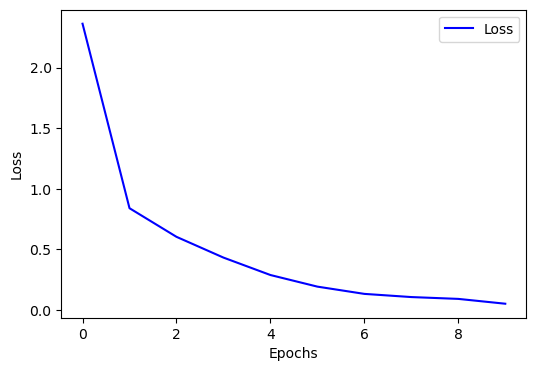

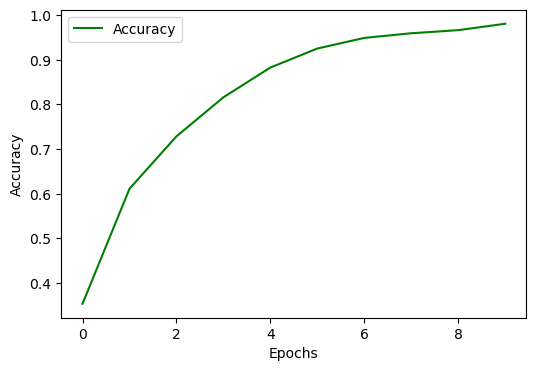

In [90]:
plt.subplots(figsize=(6,4))
plt.plot(range(epochs),training_loss,color="blue",label="Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.subplots(figsize=(6,4))
plt.plot(range(epochs),training_acc,color="green",label="Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluating the model

In [91]:
test_loss=0
test_acc= 0
test_preds=[]
test_targets = []
torch.manual_seed(42)
with torch.no_grad() : 
        for x_test , y_test in tqdm(test_dataloader) : 
            y_pred=model.forward(x_test)
            test_pred = torch.softmax(y_pred , dim=1 ).argmax(dim=1)
            test_preds.append(test_pred)
            test_targets.extend(y_test)
            
            loss=criterion(y_pred,y_test)
            test_loss+=loss
            test_acc += accuracy_score(y_test , y_pred.argmax(dim=1))
            
            
test_loss/=len(test_dataloader)
test_acc/=len(test_dataloader)
test_preds = torch.cat(test_preds)
test_targets = torch.Tensor(test_targets)

  0%|          | 0/54 [00:00<?, ?it/s]

In [92]:
print(f"The loss of the testing set is : {test_loss}\n")
print(f"The accuracy of the testing set is : {(test_acc*100):0.2f}%\n")

The loss of the testing set is : 0.1766834855079651

The accuracy of the testing set is : 93.95%



# Making predictions

In [93]:
y_preds = [] 

torch.manual_seed(42)
with torch.no_grad() : 
    for x  in tqdm(pred_dataloader) : 
        y_pred = model.forward(x) 
        
        y_pred = torch.softmax(y_pred , dim=1 ).argmax(dim=1)
        y_preds.append(y_pred)
        
y_preds = torch.cat(y_preds)

  0%|          | 0/1 [00:00<?, ?it/s]

In [94]:
x_preds_samples = next(iter(pred_dataloader))
x_preds_samples.shape

torch.Size([40, 3, 224, 224])

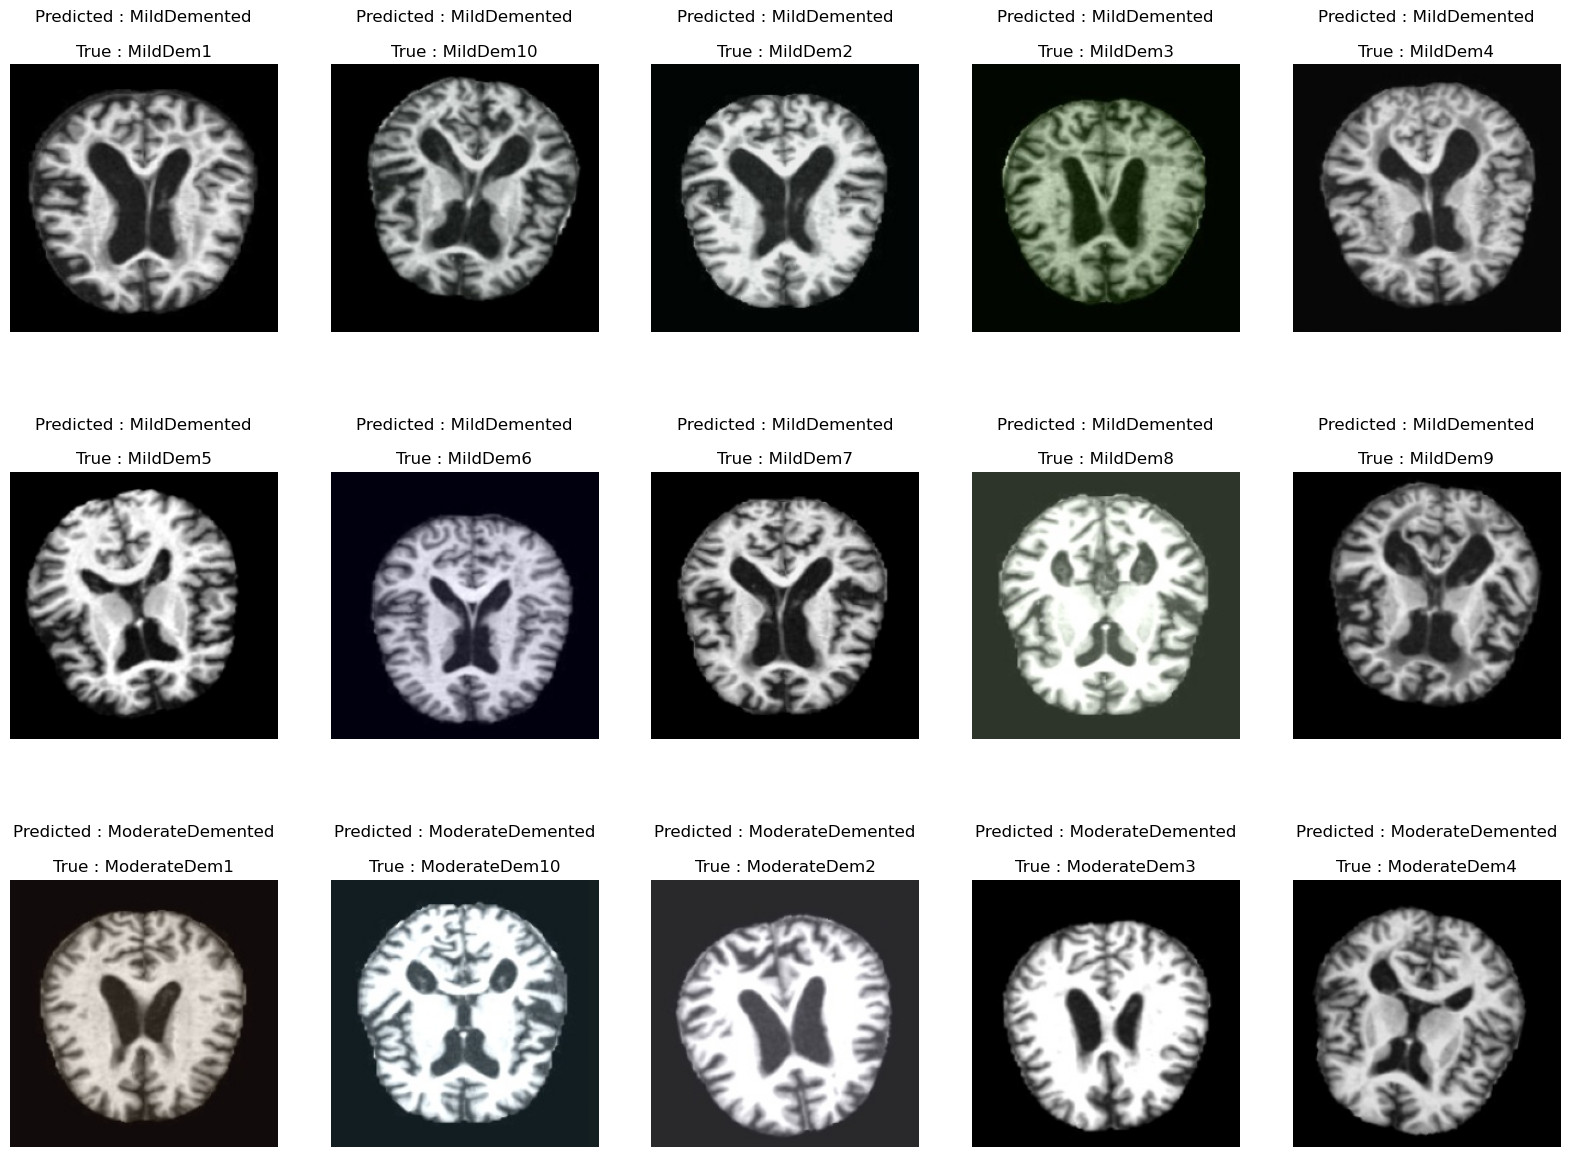

In [99]:
fig, axis = plt.subplots(3, 5, figsize=(20, 15))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        img = x_preds_samples[i].numpy()
        img = np.transpose(img, (1, 2, 0))
        ax.imshow(img)
        ax.set(title = f"Predicted : {getlabel(y_preds[i])}\n\nTrue : {pred_labels[i]}")
        ax.axis('off')

In [100]:
print(f"The accuracy of the training set is : {(training_acc[-1] * 100):0.2f}%")
print(f"The accuracy of the testing set is : {(test_acc*100):0.2f}%\n")
print(f"\nRecall : {recall_score(test_targets,test_preds,average='weighted')}")
print(f"\nPrecision : {precision_score(test_targets,test_preds,average='weighted')}")
print(f"\nF1 Score {f1_score(test_targets,test_preds,average='weighted')}\n")

The accuracy of the training set is : 98.09%
The accuracy of the testing set is : 93.95%


Recall : 0.9384298129326852

Precision : 0.9391325918495097

F1 Score 0.9385598047126689



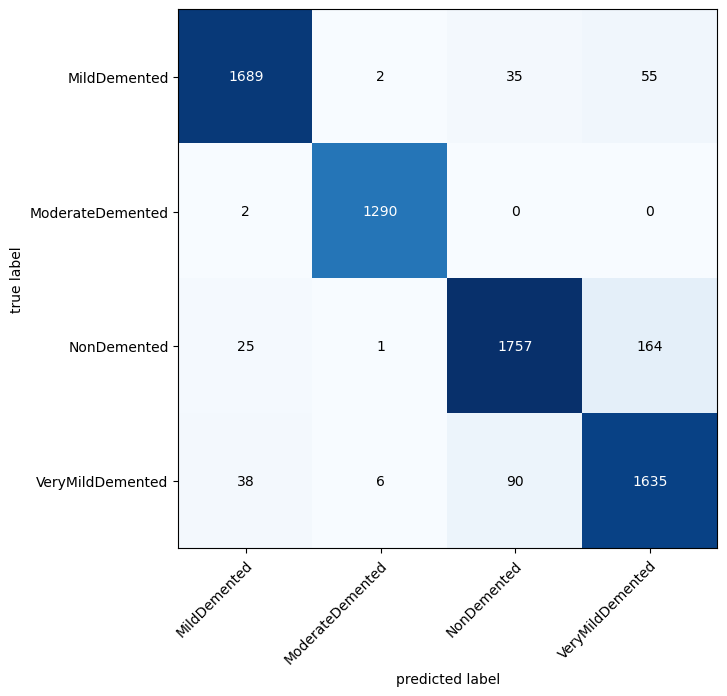

In [103]:
confmat = ConfusionMatrix(num_classes=len(classes), task='multiclass')
confmat_tensor = confmat(preds=test_preds,
                         target=test_targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=classes,
    figsize=(10, 7)
);

In [104]:
torch.save(model.state_dict(), 'Alzheimer_Classification.pt')